In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from chart_studio.plotly import plot, iplot as py
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode

import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

%matplotlib inline

In [3]:
df = pd.read_pickle('Data/FINAL2')

In [4]:
df.head()

,Origin,Date,Carrier Code,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),...,Avg_Humidity,Min_Humid,Max_Wind,Avg_Wind,Min_Wind,Max_Pressure,Avg_Pressure,Min_Pressure,Num Gates,Cert_Date
0,SFO,01/01/2018,WN,N8651A,MDW,05:15,05:15,0.0,05:28,13.0,...,82.3,67,5,1.7,0,30.2,30.2,30.1,115,10/16/2014
1,SFO,04/08/2018,WN,N8651A,PDX,20:30,21:17,47.0,21:44,27.0,...,64.6,45,26,12.0,0,30.2,30.2,30.1,115,10/16/2014
2,SFO,06/01/2018,WN,N8651A,PDX,06:20,06:18,-2.0,06:49,31.0,...,61.7,39,26,11.6,0,30.1,30.0,30.0,115,10/16/2014
3,SFO,06/02/2018,WN,N8651A,PHX,11:25,11:23,-2.0,11:33,10.0,...,58.3,33,23,10.3,0,30.0,29.9,29.9,115,10/16/2014
4,SFO,06/18/2018,WN,N8651A,MDW,09:25,09:24,-1.0,09:39,15.0,...,67.6,55,24,11.4,0,30.1,30.0,30.0,115,10/16/2014


In [5]:
df.shape

(189305, 32)

In [6]:
df.columns.tolist()

['Origin',
 'Date',
 'Carrier Code',
 'Tail Number',
 'Destination Airport',
 'Scheduled departure time',
 'Actual departure time',
 'Departure delay (Minutes)',
 'Wheels-off time',
 'Taxi-Out time (Minutes)',
 'Delay Carrier (Minutes)',
 'Delay Weather (Minutes)',
 'Delay National Aviation System (Minutes)',
 'Delay Security (Minutes)',
 'Delay Late Aircraft Arrival (Minutes)',
 'Max_Temp',
 'Avg_Temp',
 'Min_Temp',
 'Max_Dew',
 'Avg_DewPoint',
 'Min_Dew',
 'Max_Humid',
 'Avg_Humidity',
 'Min_Humid',
 'Max_Wind',
 'Avg_Wind',
 'Min_Wind',
 'Max_Pressure',
 'Avg_Pressure',
 'Min_Pressure',
 'Num Gates',
 'Cert_Date']

In [7]:
df.dtypes

Origin                                       object
Date                                         object
Carrier Code                                 object
Tail Number                                  object
Destination Airport                          object
Scheduled departure time                     object
Actual departure time                        object
Departure delay (Minutes)                   float64
Wheels-off time                              object
Taxi-Out time (Minutes)                     float64
Delay Carrier (Minutes)                     float64
Delay Weather (Minutes)                     float64
Delay National Aviation System (Minutes)    float64
Delay Security (Minutes)                    float64
Delay Late Aircraft Arrival (Minutes)       float64
Max_Temp                                     object
Avg_Temp                                     object
Min_Temp                                     object
Max_Dew                                      object
Avg_DewPoint

## **Column Definitions and Data Pre-processing**

For the sake of clarity, lets define what all these columns actually mean to get a better understanding of the date we are looking at.


**Origin** - The origin of the airport. In this case, Origin should have unique values of each airport that we chose to include in this data.  
  
**Date** - The date that this airport took off from the origin airport. 
    
**Carrier Code** - Airline code denoting which airline controls this flight  
  
**Tail Number** - Unique flight ID
  
**Destination Airport** - destination airport of this flight 
  
**Scheduled depature time** - scheduled departure time 
     
**Departure delay (Minutes)** - Delay in aircraft departure. A negative value indicates the number of minutes that an aircraft departed before its scheduled departure time.  

**Wheels-off time** - Departure time + Taxi-Out time : this is the time that the plane actually leaves the ground (takeoff)
   
**Taxi-Out time (Minutes)** - Time from leaving depature gate to actually leaving the ground  

**Delay Carrier (Minutes)** - Any aircraft delay due to delays with that specific Airline carrier  

**Delay Weather (Minutes)** - Delays resulting from weather conditions  
  
**Delay National Aviation System (Minutes)** - General nationwide delay in aviation operations  

**Delay Security (Minutes)** - Delay due to airport security issues  
   
**Delay Late Aircraft Arrival (Minutes)** - Delay due to an aircraft arriving late  

**Num_Gates** - Number of gates in that specific airport  

**Cert_Date** - The date that this specific aircraft was first certified to fly (this is a proxy for an aircraft's age)    

 


In [8]:
def get_daypart(time):
    start_times = ["05:00", "08:00", "12:00", "17:00", "21:00"]
    end_times = ["08:00", "12:00", "17:00", "21:00", "05:00"]
    day_part_list = ["Early Morning", "Morning", "Afternoon", "Evening", "Night"]
    
    for index, hour in enumerate(start_times):        
        first_time = datetime.datetime.strptime(hour,"%H:%M")
        second_time = datetime.datetime.strptime(end_times[index],"%H:%M")
        
        if time.time() >= first_time.time() and time.time() < second_time.time():
            return day_part_list[index]      
        elif index == 4:
            return day_part_list[index]

def get_day(date):    
    num = date.to_pydatetime().weekday()
    day_dict = {0 : 'Mon', 1 : 'Tues', 2 : 'Wed', 3 : 'Thurs', 4 : 'Fri', 5 : 'Sat', 6 : 'Sun'}
    return day_dict[num]

def get_month(date): 
    month_dict = {1 : 'Jan', 4 : 'Apr', 6 : 'Jun', 10 : 'Oct'}
    num = date.to_pydatetime().month
    return month_dict[num]

In [9]:
# Data Cleaning : This cell focuses on getting all the columns in the dataframe into the proper data types

df['Actual departure time'] = df['Actual departure time' ].str.replace('24', '00')

df = df[df['Cert_Date'] != 'Aircraft Description']
df = df[df['Cert_Date'] != 'None']

df['Scheduled departure time'] = df['Date'] + ' ' + df['Scheduled departure time'] 
df['Actual departure time'] = df['Date'] + ' ' + df['Actual departure time']

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

df['Scheduled departure time'] = pd.to_datetime(df['Scheduled departure time'], format="%m/%d/%Y %H:%M")
df['Actual departure time'] = pd.to_datetime(df['Actual departure time'], format="%m/%d/%Y %H:%M") 

df['Cert_Date'] = pd.to_datetime(df['Cert_Date'], format='%m/%d/%Y')

df['Age'] = (df['Date'] - df['Cert_Date']).dt.days

df['DayOfWeek'] = df['Date'].apply(lambda row: get_day(row))
df['Month'] = df['Date'].apply(lambda row: get_month(row))

df['DayPart'] = df['Actual departure time'].apply(lambda row: get_daypart(row))

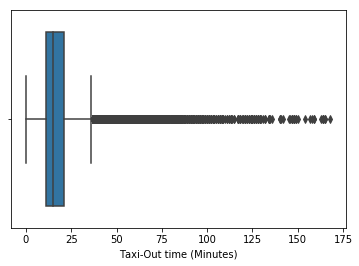

In [10]:
ax = sns.boxplot(x=df["Taxi-Out time (Minutes)"])
plt.show()

In [10]:
Q1 = df["Taxi-Out time (Minutes)"].quantile(0.25)
Q3 = df["Taxi-Out time (Minutes)"].quantile(0.75)
IQR = Q3 - Q1

bound = Q3 + 1.5 * IQR
print(f'The upper bound time limit for taxi time is : {bound}')

The upper bound time limit for taxi time is : 36.0


### Months

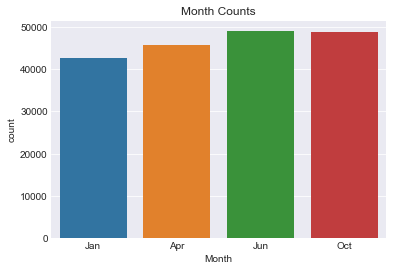

In [11]:
sns.set_style('darkgrid')
ax = sns.countplot(x="Month", data=df)
ax.set_title('Month Counts');

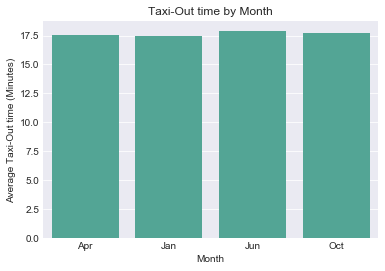

In [12]:
month_grouped = df.groupby(['Month'])['Taxi-Out time (Minutes)'].mean()

month_grouped = month_grouped.reset_index()

ax = sns.barplot(x='Month', y='Taxi-Out time (Minutes)', data=month_grouped, color='#45B39D');

ax.set_title('Taxi-Out time by Month');
ax.set_ylabel('Average Taxi-Out time (Minutes)');

### Days

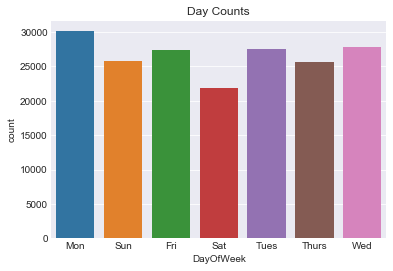

In [13]:
ax = sns.countplot(x="DayOfWeek", data=df)
ax.set_title('Day Counts');

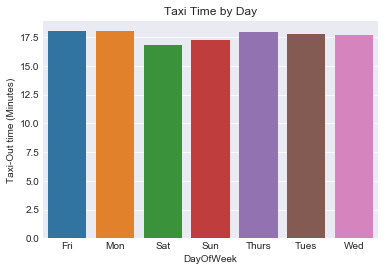

In [14]:
week_grouped = df.groupby(['DayOfWeek'])['Taxi-Out time (Minutes)'].mean()

week_grouped = week_grouped.reset_index()

ax = sns.barplot(x='DayOfWeek', y='Taxi-Out time (Minutes)', data=week_grouped);

ax.set_title('Taxi Time by Day');

### Time of Day

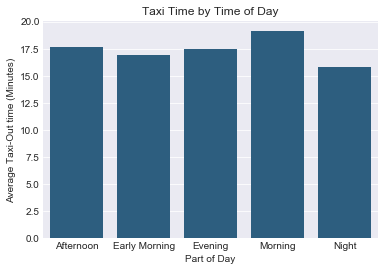

In [15]:
week_grouped = df.groupby(['DayPart'])['Taxi-Out time (Minutes)'].mean()

week_grouped = week_grouped.reset_index()

ax = sns.barplot(x='DayPart', y='Taxi-Out time (Minutes)', data=week_grouped, color='#1F618D')

ax.set_title('Taxi Time by Time of Day')
ax.set_xlabel('Part of Day')
ax.set_ylabel('Average Taxi-Out time (Minutes)');

### Airlines

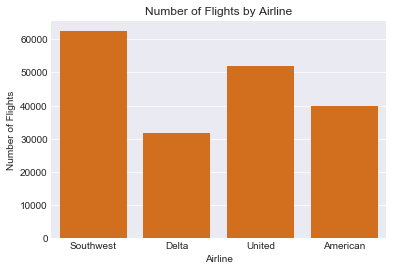

In [16]:
line_names = ['Southwest', 'Delta', 'United', 'American']
df['Carrier Code'].value_counts()
ax = sns.countplot(x="Carrier Code", data=df, color='#EF6C00')
ax.set_title('Number of Flights by Airline');
ax.set_xticklabels(line_names)
ax.set_xlabel('Airline')
ax.set_ylabel('Number of Flights');

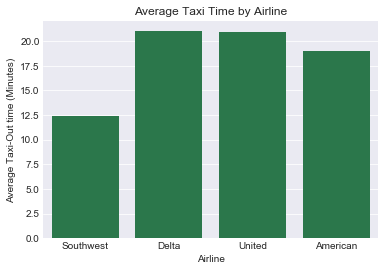

In [17]:
airline_grouped = df.groupby(['Carrier Code'])['Taxi-Out time (Minutes)'].mean()

airline_grouped = airline_grouped.reset_index()

orderl = ['WN', 'DL', 'UA', 'AA']
ax = sns.barplot(x='Carrier Code', y='Taxi-Out time (Minutes)', order=orderl, data=airline_grouped, color='#1E8449');
ax.set_xticklabels(line_names)
ax.set_xlabel('Airline')
ax.set_ylabel('Average Taxi-Out time (Minutes)')
ax.set_title('Average Taxi Time by Airline');

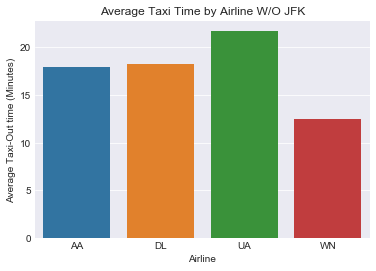

In [18]:
df2 = df.copy()
df2 = df2[(df2['Origin'] != 'JFK') & (df2['Origin'] != 'IAH') & (df2['Origin'] != 'HNL')]

airline_grouped = df2.groupby(['Carrier Code'])['Taxi-Out time (Minutes)'].mean()

airline_grouped = airline_grouped.reset_index() 

ax = sns.barplot(x='Carrier Code', y='Taxi-Out time (Minutes)', data=airline_grouped);
ax.set_ylabel('Average Taxi-Out time (Minutes)')
ax.set_xlabel('Airline')
ax.set_title('Average Taxi Time by Airline W/O JFK');

Notice that even if we remove the 3 airports that Southwest (WN) doesn't serve (JFK, IAH, HNL), Southwest still has noticeably shorter taxi times than the other 3 airlines.

### Airports

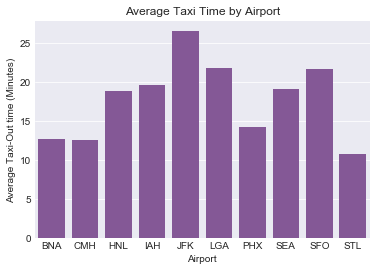

In [19]:
airport_grouped = df.groupby(['Origin'])['Taxi-Out time (Minutes)'].mean()
airport_grouped = airport_grouped.reset_index()
ax = sns.barplot(x='Origin', y='Taxi-Out time (Minutes)', data=airport_grouped, color='#884EA0')
ax.set_title('Average Taxi Time by Airport');
ax.set_ylabel('Average Taxi-Out time (Minutes)')
ax.set_xlabel('Airport');

Grouping by airport produces results as expected. Busier airports like JFK, LGA, and SFO tend to have more traffic and naturally higher taxi-out times.